In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

file = 'AAPL_Options.csv'
data = pd.read_csv(file)

In [16]:
S = 170.15
r = 5.25 / 100
q = 0.57 / 100
curr_date = np.datetime64('2023-10-30')
data['Expiration'] = pd.to_datetime(data['Expiration'], format='%m/%d/%Y')

In [17]:
# Black-Scholes model
def d1_d2(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def black_scholes_price(S, K, T, r, q, sigma, option_type='call'):
    d1, d2 = d1_d2(S, K, T, r, q, sigma)
    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

# Implied volatility
def implied_volatility(option_price, S, K, T, r, q, option_type='call'):
    func = lambda sigma: black_scholes_price(S, K, T, r, q, sigma, option_type) - option_price
    try:
        implied_vol = brentq(func, 0.001, 3.0)
    except ValueError:
        implied_vol = np.nan
    return implied_vol

In [18]:
implied_volatilities_calls = []
implied_volatilities_puts = []
strike_prices = []

for index, row in data.iterrows():
    K = row['Strike']
    option_price = row['Last Price']
    option_type = row['Type'].lower()
    exp_date = np.datetime64(row['Expiration'])

    ttm = (exp_date - curr_date).astype('timedelta64[D]').astype(int) / 365.0

    v = implied_volatility(option_price, S, K, T, r, q, option_type)

    if option_type == 'call':
        implied_volatilities_calls.append(v)
        implied_volatilities_puts.append(np.nan)
    elif option_type == 'put':
        implied_volatilities_calls.append(np.nan)
        implied_volatilities_puts.append(v)
        
    strike_prices.append(K)

results = pd.DataFrame({
    'Strike Price': strike_prices,
    'Implied Volatility (Call)': implied_volatilities_calls,
    'Implied Volatility (Put)': implied_volatilities_puts
})

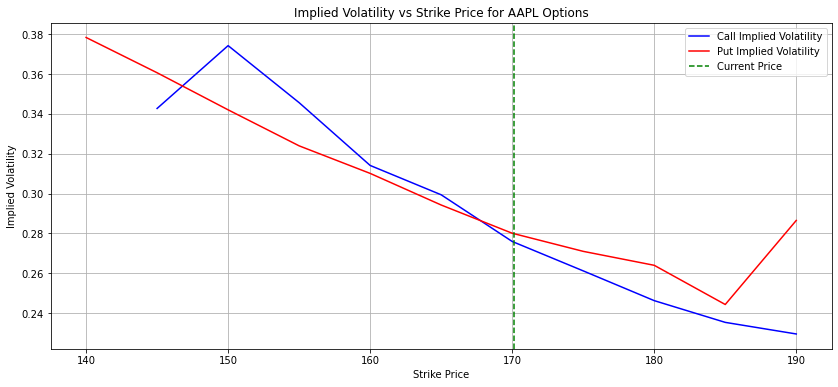

In [20]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(results['Strike Price'], results['Implied Volatility (Call)'], label='Call Implied Volatility', color='blue')
plt.plot(results['Strike Price'], results['Implied Volatility (Put)'], label='Put Implied Volatility', color='red')
plt.axvline(S, label="Current Price", linestyle='--', color='green')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike Price for AAPL Options')
plt.legend()
plt.grid(True)
plt.show()